1. 데이터 다운로드 & 폴더 구조 세팅
- Colab에서 Kaggle API를 쓰기 위한 kaggle.json 업로드
- PCB 불량 데이터셋 다운로드 후 /content/pcb_data 밑에 압축해제

In [1]:
!pip install -q ultralytics
!pip install -q opencv-python pyyaml

from google.colab import files
uploaded = files.upload()   # kaggle.json 업로드

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d akhatova/pcb-defects
!unzip -q pcb-defects.zip -d pcb_data

print("✔ 데이터 다운로드 완료")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 29.0 MB/s eta 0:00:00


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/akhatova/pcb-defects
License(s): unknown
 98% 1.84G/1.88G [00:15<00:00, 108MB/s] 
100% 1.88G/1.88G [00:15<00:00, 128MB/s]
✔ 데이터 다운로드 완료


- 원본 이미지 / 라벨 경로 정의
- YOLO 형식 데이터셋을 저장할 디렉토리 (dataset_yolo_seg)와 그 안의 train / val /test 폴더 구조 생성

2. XML → YOLO 라벨 변환 & 데이터 나누기

2-1. 클래스 이름 수집 및 인덱스 매핑

XML 어노테이션 파일을 전부 돌면서 태그를 읽어 클래스 이름 자동 수집

소문자 + 공백 _ 로 normalize

{'missing_hole': 0, 'mouse_bite': 1, ...} 이런 식으로 클래스 → 숫자 ID 매핑

In [2]:
import os
import cv2
from glob import glob
from pathlib import Path
import numpy as np
import xml.etree.ElementTree as ET
from sklearn.model_selection import train_test_split
from tqdm import tqdm

ROOT = "/content/pcb_data/PCB_DATASET"
IMG_DIR = f"{ROOT}/images"
ANN_DIR = f"{ROOT}/Annotations"

OUT_YOLO = "/content/dataset_yolo_seg"
os.makedirs(OUT_YOLO, exist_ok=True)
for split in ["train","val","test"]:
    os.makedirs(f"{OUT_YOLO}/images/{split}", exist_ok=True)
    os.makedirs(f"{OUT_YOLO}/labels/{split}", exist_ok=True)

def normalize(c):
    return c.lower().replace(" ", "_")

# 클래스 자동 수집
xml_classes = set()
for xml in glob(f"{ANN_DIR}/**/*.xml", recursive=True):
    root = ET.parse(xml).getroot()
    for obj in root.findall("object"):
        xml_classes.add(normalize(obj.findtext("name")))

CLASS2ID = {cls:i for i,cls in enumerate(sorted(xml_classes))}
print("CLASS2ID:", CLASS2ID)


CLASS2ID: {'missing_hole': 0, 'mouse_bite': 1, 'open_circuit': 2, 'short': 3, 'spur': 4, 'spurious_copper': 5}


2-2. XML bndbox → YOLO 형식 변환 함수

원본 XML의 바운딩 박스를 읽어서
→ YOLO가 요구하는 형식 (class_id, x_center, y_center, width, height)로 변환

좌표는 전부 이미지 크기로 나눈 정규화(normalized) 형태

2-3. train / val / test split & 저장

이미지–XML 쌍을 먼저 만든 뒤,

70% train, 20% test, 10% val 정도 비율로 분할

YOLO 포맷에 맞춰:

이미지는 images/split/에 저장

라벨은 labels/split/에 .txt로 저장

txt 한 줄당 한 개 객체의 바운딩 박스 정보

In [3]:
def xml_to_yolo(xml_path, img_path):
    img = cv2.imread(img_path)
    h, w = img.shape[:2]
    boxes = []

    root = ET.parse(xml_path).getroot()
    for obj in root.findall("object"):
        name = normalize(obj.findtext("name"))
        cls_id = CLASS2ID[name]

        bbox = obj.find("bndbox")
        xmin = int(bbox.findtext("xmin"))
        ymin = int(bbox.findtext("ymin"))
        xmax = int(bbox.findtext("xmax"))
        ymax = int(bbox.findtext("ymax"))

        cx = (xmin + xmax)/2 / w
        cy = (ymin + ymax)/2 / h
        bw = (xmax - xmin)/w
        bh = (ymax - ymin)/h

        boxes.append((cls_id, cx, cy, bw, bh))
    return boxes

# 이미지-XML pair 만들기
pairs=[]
for img in glob(f"{IMG_DIR}/**/*.jpg", recursive=True):
    xml = img.replace("/images/", "/Annotations/").replace(".jpg",".xml")
    if os.path.exists(xml):
        pairs.append((img,xml))

train_p, temp = train_test_split(pairs, test_size=0.3, random_state=42)
val_p, test_p = train_test_split(temp, test_size=0.33, random_state=42)

def save_split(pairs, split):
    for img_p, xml_p in tqdm(pairs, desc=f"{split} split"):
        img = cv2.imread(img_p)
        cls_folder = normalize(Path(img_p).parts[-2])
        base = f"{cls_folder}_{Path(img_p).stem}"

        out_img = f"{OUT_YOLO}/images/{split}/{base}.jpg"
        out_txt = f"{OUT_YOLO}/labels/{split}/{base}.txt"

        cv2.imwrite(out_img, img)
        boxes = xml_to_yolo(xml_p, img_p)

        with open(out_txt, "w") as f:
            for b in boxes:
                f.write(" ".join(map(str, b)) + "\n")

save_split(train_p, "train")
save_split(val_p, "val")
save_split(test_p, "test")


test split: 100%|██████████| 69/69 [00:08<00:00,  8.02it/s]


Ultralytics YOLO가 요구하는 dataset.yaml 파일 자동 생성:

데이터 경로

train/val/test 상대 경로

클래스 이름 리스트

In [4]:
import yaml

names = [None] * len(CLASS2ID)
for cls, idx in CLASS2ID.items():
    names[idx] = cls

yaml_data = {
    "path": OUT_YOLO,
    "train": "images/train",
    "val": "images/val",
    "test": "images/test",
    "names": names
}

with open(f"{OUT_YOLO}/dataset.yaml","w") as f:
    yaml.dump(yaml_data, f)

print(open(f"{OUT_YOLO}/dataset.yaml").read())


names:
- missing_hole
- mouse_bite
- open_circuit
- short
- spur
- spurious_copper
path: /content/dataset_yolo_seg
test: images/test
train: images/train
val: images/val



4. YOLO 학습 & ROI 추출

4-1. YOLO 모델 학습

사전학습된 yolov8s.pt를 로드해서

→ 방금 만든 PCB YOLO 데이터셋으로 fine-tuning 진행

In [ ]:
# from ultralytics import YOLO

# DATA_YAML = f"{OUT_YOLO}/dataset.yaml"

# # detection-only 모델 사용!
# det_model = YOLO("yolov8s.pt")   # 또는 yolov11s.pt

# det_model.train(
#     data=DATA_YAML,
#     epochs=200,
#     imgsz=1024,
#     batch=8,
#     lr0=1e-3,
#     optimizer="Adam",
#     device=0
# )

# # 학습 완료 후 best weight
# detector = YOLO("runs/detect/train/weights/best.pt")


Ultralytics 8.3.228 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/dataset_yolo_seg/dataset.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=200, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=1024, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=Adam, overlap_mask=True, patience=100, perspective=0.0, plots=Tru

KeyboardInterrupt: 

In [6]:
from ultralytics import YOLO
import torch
import os

# -------------------------
# 0. 기본 설정
# -------------------------
DATA_YAML = f"{OUT_YOLO}/dataset.yaml"
MODEL_NAME = "yolov8s.pt"
DEVICE = 0 if torch.cuda.is_available() else "cpu"

torch.manual_seed(42)  # reproducibility

# -------------------------
# 1. 모델 로드
# -------------------------
det_model = YOLO(MODEL_NAME)

# -------------------------
# 2. Train 옵션 확장
# -------------------------
det_model.train(
    data=DATA_YAML,
    epochs=200,
    imgsz=1024,
    batch=8,
    lr0=1e-3,
    optimizer="Adam",
    device=DEVICE,

    # ---- 업그레이드 옵션 ----
    project="runs/detect",
    name="exp_upgraded",
    pretrained=True,
    patience=30,
    mosaic=0.5,
    mixup=0.2,
    hsv_h=0.015, hsv_s=0.7, hsv_v=0.4,
    degrees=5, translate=0.1, scale=0.2, shear=0.1,
    fliplr=0.5, flipud=0.0,
    weight_decay=0.0005,
    amp=True,
    cache=True,
    workers=8,
)

# -------------------------
# 3. Best weight 자동 로드
# -------------------------
best_weight_path = "runs/detect/exp_upgraded/weights/best.pt"
detector = YOLO(best_weight_path)

print(f"[INFO] Best model loaded from: {best_weight_path}")


Ultralytics 8.3.230 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=True, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/dataset_yolo_seg/dataset.yaml, degrees=5, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=200, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=1024, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.2, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=0.5, multi_scale=False, name=exp_upgraded, nbs=64, nms=False, opset=None, optimize=False, optimizer=Adam, overlap_mask=True, patience=30, perspective=0.0, plots=

FileNotFoundError: test_images/ does not exist

In [7]:
# -------------------------
# 4. ★ 자동 저장되는 Predict 코드 추가 ★
# -------------------------

results = detector.predict(
    source="/content/dataset_yolo_seg/images/test",   # 이미지 or 폴더
    save=True,               # ✔ 결과 이미지 자동 저장
    save_txt=True,           # (선택) YOLO 라벨 txt 저장
    imgsz=1024,
    conf=0.3,
    project="runs/predict",
    name="exp_results"
)

print("[INFO] Prediction results saved to: runs/predict/exp_results/")



image 1/69 /content/dataset_yolo_seg/images/test/missing_hole_01_missing_hole_10.jpg: 544x1024 3 missing_holes, 68.5ms
image 2/69 /content/dataset_yolo_seg/images/test/missing_hole_01_missing_hole_14.jpg: 544x1024 3 missing_holes, 20.0ms
image 3/69 /content/dataset_yolo_seg/images/test/missing_hole_04_missing_hole_09.jpg: 832x1024 3 missing_holes, 65.0ms
image 4/69 /content/dataset_yolo_seg/images/test/missing_hole_05_missing_hole_01.jpg: 896x1024 3 missing_holes, 74.1ms
image 5/69 /content/dataset_yolo_seg/images/test/missing_hole_05_missing_hole_06.jpg: 896x1024 5 missing_holes, 28.8ms
image 6/69 /content/dataset_yolo_seg/images/test/missing_hole_06_missing_hole_08.jpg: 832x1024 5 missing_holes, 28.9ms
image 7/69 /content/dataset_yolo_seg/images/test/missing_hole_06_missing_hole_10.jpg: 832x1024 5 missing_holes, 27.9ms
image 8/69 /content/dataset_yolo_seg/images/test/missing_hole_08_missing_hole_01.jpg: 800x1024 5 missing_holes, 72.4ms
image 9/69 /content/dataset_yolo_seg/images/tes

In [9]:
from pathlib import Path
import os
import cv2

save_crop_dir = "runs/predict/exp_results/crops"
os.makedirs(save_crop_dir, exist_ok=True)

for r in results:
    img = r.orig_img  # 원본 이미지는 한번만 가져도 됨
    img_name = Path(r.path).stem  # 여기서 Path로 감싸서 stem 사용!

    for i, box in enumerate(r.boxes.xyxy):
        x1, y1, x2, y2 = box.cpu().numpy().astype(int)
        roi = img[y1:y2, x1:x2]

        save_path = f"{save_crop_dir}/{img_name}_crop_{i}.jpg"
        cv2.imwrite(save_path, roi)


In [ ]:
# 학습 완료 후 best weight
# detector = YOLO("runs/detect/train/weights/best.pt")

학습 후 가장 성능 좋은 가중치(best.pt)를 불러와 최종 detector로 사용

In [13]:
def extract_rois(image_path, conf=0.25):
    results = detector(image_path)[0]
    img = cv2.imread(image_path)

    rois = []
    boxes = []

    for box in results.boxes:
        if box.conf < conf:
            continue

        x1, y1, x2, y2 = box.xyxy[0].cpu().numpy().astype(int)
        roi = img[y1:y2, x1:x2]

        rois.append(roi)
        boxes.append((x1, y1, x2, y2))

    return img, rois, boxes


YOLO detector를 호출해서 불량 영역 바운딩 박스 리스트를 가져옴

각 박스마다:

원본 이미지에서 잘라낸 ROI(roi)

바운딩 박스 좌표((x1, y1, x2, y2))

반환: 원본 이미지, ROI 리스트, 박스 좌표 리스트

5. ROI에서 자동 마스크 만들기 (Pseudo Ground Truth)

Ground Truth 마스크가 없기 때문에, 자동으로 “의사 정답(pseudo mask)” 생성:

ROI를 그레이스케일로 변환

Gaussian Blur로 노이즈 제거

Otsu Threshold로 어두운 영역(불량일 가능성 높은 부분) 이진화

Morphology Open/Close로 작은 점 제거 + 영역 매끄럽게 만들기

In [14]:
# def create_auto_mask(roi):
#     """
#     ROI에서 자동으로 결함 mask를 생성
#     - grayscale 변환
#     - Otsu threshold로 불량 영역 추출
#     - morphology로 정제
#     """
#     gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)

#     # 잡음 제거
#     blur = cv2.GaussianBlur(gray, (5,5), 0)

#     # 불량은 대체로 어두움 → Otsu threshold 사용
#     _, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

#     # 작은 점 제거
#     kernel = np.ones((3,3), np.uint8)
#     mask = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

#     # 클러스터 확장해서 mask 매끄럽게
#     mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=2)

#     return mask

import cv2
import numpy as np
import os
from pathlib import Path

def create_auto_mask(roi, save_prefix=None):
    """
    ROI에서 자동으로 결함 mask 생성 + 단계별 이미지 저장
    save_prefix: 저장 파일명 앞에 붙일 이름 (예: "img1_roi0")
    """

    # 저장 경로 생성
    if save_prefix is not None:
        base_dir = Path("debug_masks")
        dirs = ["gray", "blur", "thresh", "final"]
        for d in dirs:
            (base_dir / d).mkdir(parents=True, exist_ok=True)

    # 1) grayscale
    gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    if save_prefix:
        cv2.imwrite(f"debug_masks/gray/{save_prefix}_gray.png", gray)

    # 2) blur
    blur = cv2.GaussianBlur(gray, (5,5), 0)
    if save_prefix:
        cv2.imwrite(f"debug_masks/blur/{save_prefix}_blur.png", blur)

    # 3) threshold(Otsu)
    _, thresh = cv2.threshold(
        blur, 0, 255,
        cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU
    )
    if save_prefix:
        cv2.imwrite(f"debug_masks/thresh/{save_prefix}_thresh.png", thresh)

    # 4) morphology
    kernel = np.ones((3,3), np.uint8)
    mask = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=2)
    if save_prefix:
        cv2.imwrite(f"debug_masks/final/{save_prefix}_final.png", mask)

    return mask



6. U-Net 학습용 Dataset (ROI + Mask) 만들기

YOLO가 잘라준 ROI들마다 create_auto_mask()로 마스크를 만들고

images/idx.png, masks/idx.png로 저장

결국 U-Net 학습에 바로 쓸 수 있는 이미지–마스크 페어 데이터셋이 자동 생성됨

In [22]:
def build_unet_dataset(img_dir, out_dir):
    os.makedirs(f"{out_dir}/images", exist_ok=True)
    os.makedirs(f"{out_dir}/masks", exist_ok=True)

    idx = 0
    for img_path in sorted(glob(f"{img_dir}/*.jpg")):
        original, rois, boxes = extract_rois(img_path)

        for roi in rois:
            # mask = create_auto_mask(roi)
            mask = create_auto_mask(roi, save_prefix=f"{idx}")


            cv2.imwrite(f"{out_dir}/images/{idx}.png", roi)
            cv2.imwrite(f"{out_dir}/masks/{idx}.png", mask)
            idx += 1

    print(f"생성 완료! 총 {idx}개의 ROI+mask가 생성됨.")


In [23]:
build_unet_dataset(
    "/content/dataset_yolo_seg/images/train",
    "/content/unet_dataset"
)



image 1/1 /content/dataset_yolo_seg/images/train/missing_hole_01_missing_hole_01.jpg: 544x1024 3 missing_holes, 20.7ms
Speed: 4.3ms preprocess, 20.7ms inference, 4.4ms postprocess per image at shape (1, 3, 544, 1024)
Results saved to /content/runs/predict/exp_results
552 labels saved to /content/runs/predict/exp_results/labels

image 1/1 /content/dataset_yolo_seg/images/train/missing_hole_01_missing_hole_04.jpg: 544x1024 3 missing_holes, 19.9ms
Speed: 4.3ms preprocess, 19.9ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 1024)
Results saved to /content/runs/predict/exp_results
552 labels saved to /content/runs/predict/exp_results/labels

image 1/1 /content/dataset_yolo_seg/images/train/missing_hole_01_missing_hole_05.jpg: 544x1024 4 missing_holes, 19.9ms
Speed: 4.0ms preprocess, 19.9ms inference, 1.4ms postprocess per image at shape (1, 3, 544, 1024)
Results saved to /content/runs/predict/exp_results
552 labels saved to /content/runs/predict/exp_results/labels

image 1/1

In [17]:
def unet_segment(roi):
    ori_h, ori_w = roi.shape[:2]

    roi_resized = cv2.resize(roi, (256,256))
    inp = roi_resized.astype(np.float32) / 255.
    inp = np.expand_dims(inp, axis=0)

    mask = unet.predict(inp)[0]
    mask = (mask > 0.5).astype(np.uint8) * 255

    mask = cv2.resize(mask, (ori_w, ori_h))
    return mask


In [18]:
def overlay_masks(original, boxes, masks):
    out = original.copy()

    for (x1,y1,x2,y2), mask in zip(boxes, masks):
        mask_colored = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
        colored = np.zeros_like(mask_colored)
        colored[:,:,1] = mask  # green highlight

        blended = cv2.addWeighted(out[y1:y2, x1:x2], 0.7, colored, 0.3, 0)
        out[y1:y2, x1:x2] = blended

    return out


7. U-Net 학습 파트

7-1. Data Generator

tf.keras.utils.Sequence를 상속한 커스텀 제너레이터

배치 단위로:

이미지는 256×256, 0~1로 스케일링

마스크는 grayscale, 0~1로 스케일링


In [24]:
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import img_to_array, load_img

class UNetGenerator(Sequence):
    def __init__(self, img_dir, mask_dir, batch_size=8, img_size=(256,256)):
        self.img_paths = sorted(glob(f"{img_dir}/*.png"))
        self.mask_paths = sorted(glob(f"{mask_dir}/*.png"))
        self.batch_size = batch_size
        self.img_size = img_size

    def __len__(self):
        return len(self.img_paths) // self.batch_size

    def __getitem__(self, idx):
        batch_imgs = self.img_paths[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_masks = self.mask_paths[idx*self.batch_size:(idx+1)*self.batch_size]

        X, y = [], []
        for img_p, mask_p in zip(batch_imgs, batch_masks):
            img = load_img(img_p, target_size=self.img_size)
            mask = load_img(mask_p, target_size=self.img_size, color_mode="grayscale")

            X.append(img_to_array(img) / 255.)
            y.append(img_to_array(mask) / 255.)

        return np.array(X), np.array(y)


In [25]:
from tensorflow.keras import layers, Model

def build_unet(input_shape=(256,256,3)):
    inputs = layers.Input(input_shape)

    # Encoder
    c1 = layers.Conv2D(32, 3, activation="relu", padding="same")(inputs)
    c1 = layers.Conv2D(32, 3, activation="relu", padding="same")(c1)
    p1 = layers.MaxPool2D()(c1)

    c2 = layers.Conv2D(64, 3, activation="relu", padding="same")(p1)
    c2 = layers.Conv2D(64, 3, activation="relu", padding="same")(c2)
    p2 = layers.MaxPool2D()(c2)

    c3 = layers.Conv2D(128, 3, activation="relu", padding="same")(p2)
    c3 = layers.Conv2D(128, 3, activation="relu", padding="same")(c3)

    # Decoder
    u4 = layers.UpSampling2D()(c3)
    u4 = layers.concatenate([u4, c2])
    c4 = layers.Conv2D(64, 3, activation="relu", padding="same")(u4)
    c4 = layers.Conv2D(64, 3, activation="relu", padding="same")(c4)

    u5 = layers.UpSampling2D()(c4)
    u5 = layers.concatenate([u5, c1])
    c5 = layers.Conv2D(32, 3, activation="relu", padding="same")(u5)
    c5 = layers.Conv2D(32, 3, activation="relu", padding="same")(c5)

    outputs = layers.Conv2D(1, 1, activation="sigmoid")(c5)

    model = Model(inputs, outputs)
    return model


7-2. U-Net 빌드 & 학습

경량 U-Net 구조(Encoder–Decoder + Skip connection)

Binary segmentation이라 loss='binary_crossentropy', 출력 채널 1, sigmoid 사용


In [26]:
train_gen = UNetGenerator("/content/unet_dataset/images",
                          "/content/unet_dataset/masks",
                          batch_size=8)

unet = build_unet((256,256,3))
unet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

unet.fit(train_gen, epochs=20)


Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


257/257 ━━━━━━━━━━━━━━━━━━━━ 48s 106ms/step - accuracy: 0.8058 - loss: 0.4076
Epoch 2/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 27s 104ms/step - accuracy: 0.9382 - loss: 0.1734
Epoch 3/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 27s 103ms/step - accuracy: 0.9472 - loss: 0.1485
Epoch 4/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 27s 105ms/step - accuracy: 0.9449 - loss: 0.1538
Epoch 5/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 27s 104ms/step - accuracy: 0.9463 - loss: 0.1532
Epoch 6/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 27s 103ms/step - accuracy: 0.9438 - loss: 0.1583
Epoch 7/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 27s 104ms/step - accuracy: 0.9520 - loss: 0.1360
Epoch 8/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 27s 104ms/step - accuracy: 0.9528 - loss: 0.1360
Epoch 9/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 27s 103ms/step - accuracy: 0.9402 - loss: 0.1661
Epoch 10/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 27s 104ms/step - accuracy: 0.9532 - loss: 0.1327
Epoch 11/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 27s 104ms/step - accuracy: 0.9447 - loss: 0.1522
Epoch 12/20
257/257 ━━━━━━━━━━

In [27]:
unet.save_weights("unet_best.weights.h5")

In [28]:
unet.load_weights("unet_best.weights.h5")

8. U-Net 추론 + 결과 합성

8-1. ROI 하나에 대한 세그멘테이션

ROI를 256×256으로 리사이즈 → U-Net 통과 → 0~1 확률 출력

0.5 기준으로 이진화 → 다시 원래 ROI 크기로 리사이즈해서 반환

In [29]:
def unet_segment(roi):
    h, w = roi.shape[:2]
    inp = cv2.resize(roi, (256,256)).astype(np.float32)/255.
    mask = unet.predict(np.expand_dims(inp, 0))[0]
    mask = (mask > 0.5).astype(np.uint8)*255
    mask = cv2.resize(mask, (w,h))
    return mask


8-2. 원본 이미지 위에 마스크 입히기

바운딩 박스 영역에 대해:

마스크를 초록색 채널에 얹고

원본과 0.7 : 0.3 비율로 합성해서 불량 부분이 초록색으로 강조된 결과 이미지 생성

In [34]:
def overlay(original, boxes, masks):
    out = original.copy()
    for (x1,y1,x2,y2), mask in zip(boxes, masks):
        colored = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
        green = np.zeros_like(colored)
        green[:,:,1] = mask
        out[y1:y2, x1:x2] = cv2.addWeighted(out[y1:y2,x1:x2], 0.7, green, 0.3, 0)
    return out

def overlay_red(original, boxes, masks):
  out = original.copy()

  for (x1, y1, x2, y2), mask in zip(boxes, masks):
      # mask를 3채널로 변환
      mask_color = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)

      # 빨간색 영역 생성
      red = np.zeros_like(mask_color)
      red[:, :, 2] = mask  # R 채널만 활성화 → 빨간색

      # 반투명 합성: 원본 70% + 빨강 30%
      blended = cv2.addWeighted(
          out[y1:y2, x1:x2], 0.7,
          red, 0.3,
          0
      )

      out[y1:y2, x1:x2] = blended

  return out



In [35]:
from glob import glob
from pathlib import Path
import os
import cv2

save_overlay_dir = "runs/predict/overlay_red"
os.makedirs(save_overlay_dir, exist_ok=True)

test_images = glob("/content/dataset_yolo_seg/images/test/*.jpg")

for img_path in test_images:
    original, rois, boxes = extract_rois(img_path)

    if len(rois) == 0:
        continue

    # U-Net masks 생성
    masks = [unet_segment(roi) for roi in rois]

    # 빨간색 overlay 생성
    overlay_img = overlay_red(original, boxes, masks)

    # 저장
    out_name = f"{Path(img_path).stem}_overlay_red.png"
    cv2.imwrite(f"{save_overlay_dir}/{out_name}", overlay_img)

print("🎨 빨간색 segmentation overlay 이미지 저장 완료!")



image 1/1 /content/dataset_yolo_seg/images/test/short_11_short_04.jpg: 1024x1024 5 shorts, 34.3ms
Speed: 12.3ms preprocess, 34.3ms inference, 2.2ms postprocess per image at shape (1, 3, 1024, 1024)
Results saved to /content/runs/predict/exp_results
552 labels saved to /content/runs/predict/exp_results/labels
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step

image 1/1 /content/dataset_yolo_seg/images/test/mouse_bite_05_mouse_bite_02.jpg: 896x1024 5 mouse_bites, 30.6ms
Speed: 10.4ms preprocess, 30.6ms inference, 2.4ms postprocess per image at shape (1, 3, 896, 1024)
Results saved to /content/runs/predict/exp_results
552 labels saved to /content/runs/predict/exp_results/labels
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━

In [31]:
# save_overlay_dir = "runs/predict/overlay"
# os.makedirs(save_overlay_dir, exist_ok=True)

# test_images = glob("/content/dataset_yolo_seg/images/test/*.jpg")

# for img_path in test_images:
#     original, rois, boxes = extract_rois(img_path)

#     # U-Net masks
#     masks = [unet_segment(roi) for roi in rois]

#     # overlay 생성
#     # overlay_img = overlay(original, boxes, masks)
#     overlay_img = overlay_red(original, boxes, masks)

#     out_name = f"{Path(img_path).stem}_overlay.png"
#     cv2.imwrite(f"{save_overlay_dir}/{out_name}", overlay_img)

# print("🎨 Overlay 이미지 저장 완료!")


image 1/1 /content/dataset_yolo_seg/images/test/short_11_short_04.jpg: 1024x1024 5 shorts, 33.1ms
Speed: 13.1ms preprocess, 33.1ms inference, 2.1ms postprocess per image at shape (1, 3, 1024, 1024)
Results saved to /content/runs/predict/exp_results
552 labels saved to /content/runs/predict/exp_results/labels
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step

image 1/1 /content/dataset_yolo_seg/images/test/mouse_bite_05_mouse_bite_02.jpg: 896x1024 5 mouse_bites, 15.5ms
Speed: 9.3ms preprocess, 15.5ms inference, 1.4ms postprocess per image at shape (1, 3, 896, 1024)
Results saved to /content/runs/predict/exp_results
552 labels saved to /content/runs/predict/exp_results/labels
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

8-3. YOLO → U-Net까지 한 번에 돌리는 파이프라인

입력: 원본 PCB 이미지 경로

출력: YOLO가 찾은 영역에 대해 U-Net 마스크를 올려서 색칠한 최종 결과 이미지

In [36]:
def full_pipeline(image_path):
    original, rois, boxes = extract_rois(image_path)
    masks = [unet_segment(roi) for roi in rois]
    result = overlay(original, boxes, masks)
    return result


image 1/1 /content/dataset_yolo_seg/images/test/open_circuit_01_open_circuit_04.jpg: 544x1024 3 open_circuits, 21.1ms
Speed: 13.5ms preprocess, 21.1ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 1024)
Results saved to /content/runs/predict/exp_results
552 labels saved to /content/runs/predict/exp_results/labels


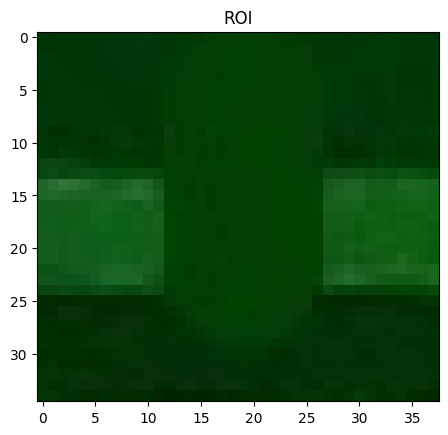

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


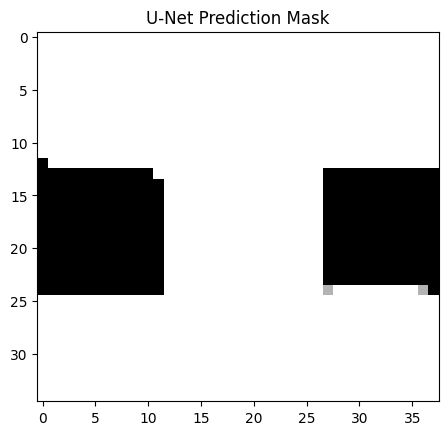

In [39]:
import matplotlib.pyplot as plt

img_path = "/content/dataset_yolo_seg/images/test/open_circuit_01_open_circuit_04.jpg"

original, rois, boxes = extract_rois(img_path, conf=0.05)

plt.imshow(cv2.cvtColor(rois[0], cv2.COLOR_BGR2RGB))
plt.title("ROI")
plt.show()

mask = unet_segment(rois[0])
plt.imshow(mask, cmap='gray')
plt.title("U-Net Prediction Mask")
plt.show()



10. IoU / Dice 계산 & 테스트셋 전체 평가

mask_true = create_auto_mask()로 만든 자동 마스크 (pseudo GT)

mask_pred = U-Net 예측 마스크

둘 간의 교집합/합집합으로 IoU, Dice 계산

In [37]:
import numpy as np

def compute_iou(mask_true, mask_pred):
    # binary masks (0 or 255)
    mask_true = (mask_true > 127).astype(np.uint8)
    mask_pred = (mask_pred > 127).astype(np.uint8)

    intersection = np.logical_and(mask_true, mask_pred).sum()
    union = np.logical_or(mask_true, mask_pred).sum()

    if union == 0:
        return 1.0 if intersection == 0 else 0.0
    return intersection / union


def compute_dice(mask_true, mask_pred):
    mask_true = (mask_true > 127).astype(np.uint8)
    mask_pred = (mask_pred > 127).astype(np.uint8)

    intersection = np.logical_and(mask_true, mask_pred).sum()
    total = mask_true.sum() + mask_pred.sum()

    if total == 0:
        return 1.0 if intersection == 0 else 0.0
    return 2 * intersection / total


10-2. ROI별 출력 & 폴더 단위 평균 평가

특정 이미지 안에 있는 각 ROI별로 IoU/Dice 출력

IoU 0.88 ~ 0.96, Dice 0.93 ~ 0.98 수준의 매우 높은 값이 나오는 걸 확인할 수 있음

In [40]:
img_path = "/content/dataset_yolo_seg/images/test/open_circuit_01_open_circuit_04.jpg"

original, rois, boxes = extract_rois(img_path, conf=0.05)

for i, roi in enumerate(rois):
    true_mask = create_auto_mask(roi)
    pred_mask = unet_segment(roi)

    iou = compute_iou(true_mask, pred_mask)
    dice = compute_dice(true_mask, pred_mask)

    print(f"[ROI {i}] IoU: {iou:.4f}, Dice: {dice:.4f}")



image 1/1 /content/dataset_yolo_seg/images/test/open_circuit_01_open_circuit_04.jpg: 544x1024 3 open_circuits, 19.9ms
Speed: 4.2ms preprocess, 19.9ms inference, 1.4ms postprocess per image at shape (1, 3, 544, 1024)
Results saved to /content/runs/predict/exp_results
552 labels saved to /content/runs/predict/exp_results/labels
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
[ROI 0] IoU: 0.9861, Dice: 0.9930
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
[ROI 1] IoU: 0.9691, Dice: 0.9843
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
[ROI 2] IoU: 0.9947, Dice: 0.9973


테스트셋 폴더 전체 이미지에 대해 ROI를 모두 돌면서 평균 IoU, Dice 계산

최종적으로 “U-Net이 PCB 불량 영역을 얼마나 잘 세그멘테이션 했는지”를 정량적으로 보여주는 부분

In [41]:
from glob import glob

def evaluate_unet_on_folder(folder):
    img_paths = sorted(glob(f"{folder}/*.jpg"))
    total_iou = 0
    total_dice = 0
    count = 0

    for img_path in img_paths:
        original, rois, boxes = extract_rois(img_path, conf=0.05)

        for roi in rois:
            true_mask = create_auto_mask(roi)
            pred_mask = unet_segment(roi)

            iou = compute_iou(true_mask, pred_mask)
            dice = compute_dice(true_mask, pred_mask)

            total_iou += iou
            total_dice += dice
            count += 1

    avg_iou = total_iou / count if count > 0 else 0
    avg_dice = total_dice / count if count > 0 else 0

    print(f"\n📊 U-Net 성능 평가 결과 ({count}개의 ROI)")
    print(f"   평균 IoU  : {avg_iou:.4f}")
    print(f"   평균 Dice : {avg_dice:.4f}")

    return avg_iou, avg_dice


In [42]:
evaluate_unet_on_folder("/content/dataset_yolo_seg/images/test")



image 1/1 /content/dataset_yolo_seg/images/test/missing_hole_01_missing_hole_10.jpg: 544x1024 3 missing_holes, 29.4ms
Speed: 6.6ms preprocess, 29.4ms inference, 2.3ms postprocess per image at shape (1, 3, 544, 1024)
Results saved to /content/runs/predict/exp_results
552 labels saved to /content/runs/predict/exp_results/labels
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step

image 1/1 /content/dataset_yolo_seg/images/test/missing_hole_01_missing_hole_14.jpg: 544x1024 3 missing_holes, 20.0ms
Speed: 6.3ms preprocess, 20.0ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 1024)
Results saved to /content/runs/predict/exp_results
552 labels saved to /content/runs/predict/exp_results/labels
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step

image 1/1 /content/dataset_yolo_seg/images/test/missing_hole_04_missing_hole_09.jpg: 832x1024 3 missing_holes, 30

(np.float64(0.9113103751255164), np.float64(0.9477174355486394))

In [43]:
for img_path in test_images:
    results = detector(img_path)[0]
    print(img_path, "→ Detected:", len(results.boxes))



image 1/1 /content/dataset_yolo_seg/images/test/short_11_short_04.jpg: 1024x1024 5 shorts, 44.0ms
Speed: 61.7ms preprocess, 44.0ms inference, 6.9ms postprocess per image at shape (1, 3, 1024, 1024)
Results saved to /content/runs/predict/exp_results
552 labels saved to /content/runs/predict/exp_results/labels
/content/dataset_yolo_seg/images/test/short_11_short_04.jpg → Detected: 5

image 1/1 /content/dataset_yolo_seg/images/test/mouse_bite_05_mouse_bite_02.jpg: 896x1024 5 mouse_bites, 31.5ms
Speed: 26.3ms preprocess, 31.5ms inference, 5.8ms postprocess per image at shape (1, 3, 896, 1024)
Results saved to /content/runs/predict/exp_results
552 labels saved to /content/runs/predict/exp_results/labels
/content/dataset_yolo_seg/images/test/mouse_bite_05_mouse_bite_02.jpg → Detected: 5

image 1/1 /content/dataset_yolo_seg/images/test/missing_hole_05_missing_hole_01.jpg: 896x1024 3 missing_holes, 30.6ms
Speed: 21.6ms preprocess, 30.6ms inference, 5.4ms postprocess per image at shape (1, 3, 